In [1]:
import os

# Set the base directory (in case you want to
# keep a notebook in a subfolder)
subdir = '/examples'
basedir = os.environ['HOME'] + subdir

os.chdir(basedir)

In [2]:
# External package imports
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Local package imports
from libs.GcmData.GcmDataLoaderExocam import GcmDataLoaderExocam
import libs.utils

# Adjust font size of plots with this
# matplotlib.rcParams.update({ 'font.size': 16 })

## Functions

In [3]:
def plot_quiver(
    data_u,
    data_v,
    ax,
    coarsen_kwargs={},
    quiver_kwargs={},
    quiverkey_opts={
        'X': 0,
        'Y': 0,
        'U': 5,
        'color': '#000',
        'label': '5 $ms^{-1}$',
        'labelpos': 'E'
    }
):
    '''
    Function `plot_quiver`

    Inputs:
    - `data_u`:
        description: wind in u direction
        type: xarray.DataArray
    - `data_v`:
        description: wind in v direction
        type: xarray.DataArray
    - `ax`:
        description: axis to plot on
        type: matplotlib.axes._subplots.AxesSubplot
    - `coarsen_kwargs`:
        description: a dict of keyword arguments to pass to
            coarsen function (to reduce number of quivers
            in plot and speed up plotting time). See
            https://xarray.pydata.org/en/stable/generated/xarray.DataArray.coarsen.html
        default: {}
        type: dict
    - `quiver_kwargs`:
        description: a dict of keyword arguments to pass to
            quiver plot function. See
            https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.quiver.html#matplotlib.axes.Axes.quiver
        default: {}
        type: dict
    - `quiverkey_opts`:
        description: a dict of keyword arguments to pass to
            quiverkey function. See
            https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiverkey.html
        default: {
            'X': 0,
            'Y': 0,
            'U': 5,
            'color': '#000',
            'label': '5 $ms^{-1}$',
            'labelpos': 'E'
        }
        type: dict
    '''
    data_u_coarse = data_u
    data_v_coarse = data_v

    if coarsen_kwargs:
        # Coarsen data for fewer quivers in plot, also speeds up plotting time
        data_u_coarse = data_u.coarsen(**coarsen_kwargs).mean()
        data_v_coarse = data_v.coarsen(**coarsen_kwargs).mean()

    x, y = np.meshgrid(
        data_u_coarse.lon.values,
        data_u_coarse.lat.values
    )

    u_plot = data_u_coarse
    v_plot = data_v_coarse

    if 'transform' in quiver_kwargs:
        # Apply fix for polar (e.g. stereographic or azimuthal) projections
        u_trans = data_u_coarse / np.cos(y / 180 * np.pi) 
        v_trans = data_v_coarse
        mag = (data_u_coarse**2 + data_v_coarse**2)**0.5
        mag_trans = (u_trans**2 + v_trans**2)**0.5
        u_plot = u_trans * mag / mag_trans
        v_plot = v_trans * mag / mag_trans

    # Quiver plotting function
    q = ax.quiver(
        x,
        y,
        u_plot.values,
        v_plot.values,
        **quiver_kwargs
    )

    quiverkey_opts and ax.quiverkey(Q=q, **quiverkey_opts)
    
    return q

In [4]:
def plot_streamlines(
    data_u,
    data_v,
    ax,
    streamplot_kwargs={},
):
    '''
    Function `plot_streamlines`

    Inputs:
    - `data_u`:
        description: wind in u direction
        type: xarray.DataArray
    - `data_v`:
        description: wind in v direction
        type: xarray.DataArray
    - `ax`:
        description: axis to plot on
        type: matplotlib.axes._subplots.AxesSubplot
    - `streamplot_kwargs`:
        description: a dict of keyword arguments to pass to
            streamplot plot function. See
            https://matplotlib.org/stable/gallery/images_contours_and_fields/plot_streamplot.html
        default: {}
        type: dict
    '''    
    x, y = np.meshgrid(
        data_u.lon.values,
        data_v.lat.values
    )

    # Plot
    subfig = ax.streamplot(
        x,
        y,
        data_u.values,
        data_v.values,
        **streamplot_kwargs
    )
    
    return subfig

## Data

In [5]:
loader = GcmDataLoaderExocam(
    id='thai-hab1',
    path='data/{id}.cam.h0.*.nc'
)

gcm_data = loader.load()

Centering longitude
Standardising vars


In [6]:
# Average over time for examples
gcm_slice = gcm_data\
    .sel(time=slice('0012-01-01', '0015-01-01'))\
    .mean('time')

## Plotting

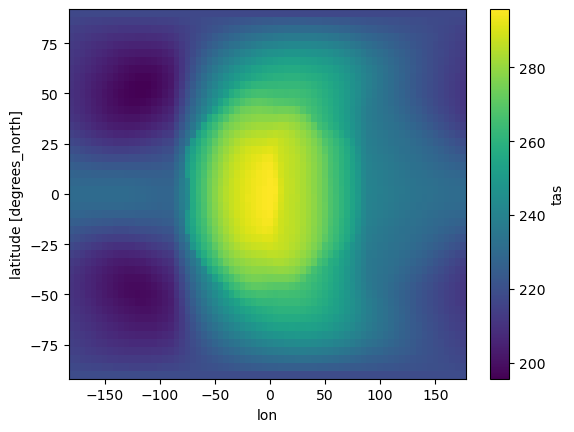

In [7]:
# Select a surface variable, e.g. surface temperature `tas`.
# You can do a simple spatial plot by passing in the keys
# for longitude `lon` and latitude `lat` as x,y axes in
# the plotting function
gcm_slice\
    ['tas']\
    .plot(x='lon', y='lat')

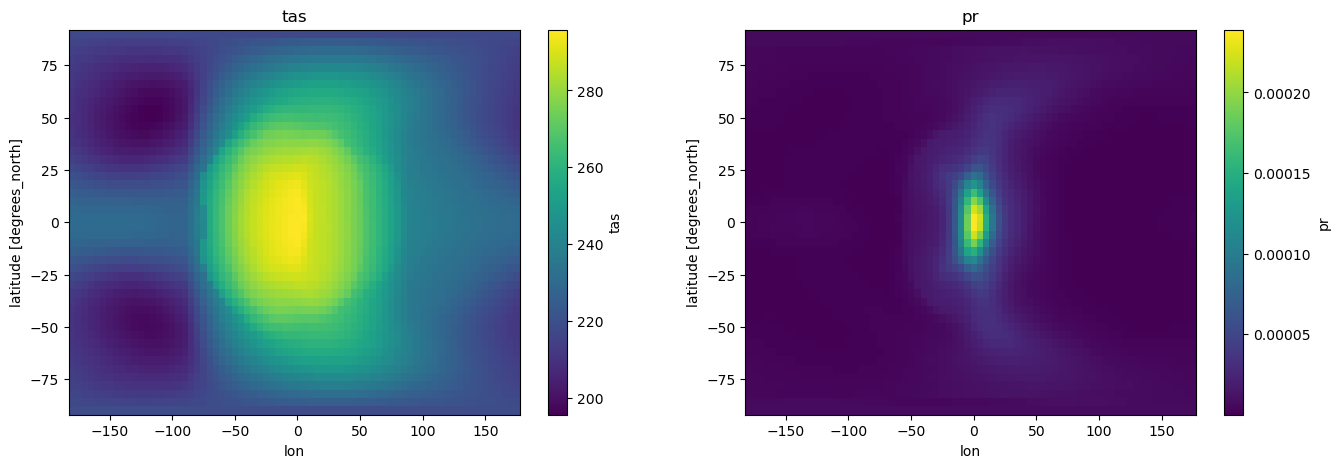

In [8]:
# We can also use the create_figure utility function
# to create our own figure and plot to that:

# Create matplotlib figure with axes
fig, axs = libs.utils.create_figure(
    shape=(1, 2), # Figure with 1x2 subfigures
    height=5,     # Subfigure has height of '5'
    width=8       # Subfigure has width of 5
)

# `tas` surface air temperature, and `pr` precipitation
variables = ['tas', 'pr']

for i, var in enumerate(variables):
    gcm_slice\
        [var]\
        .plot(
            ax=axs[i],
            x='lon',
            y='lat'
        )

    axs[i].set_title(var)

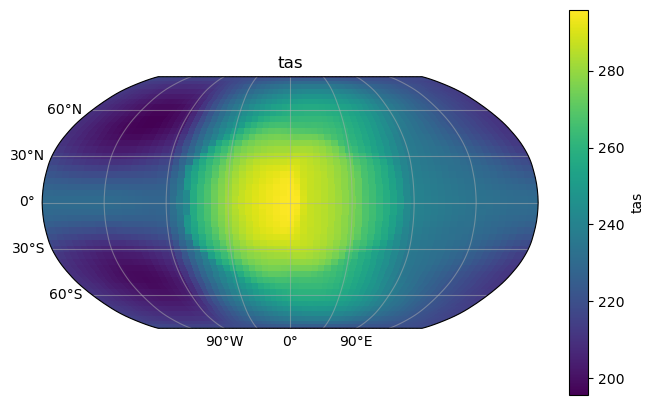

In [9]:
# Create matplotlib figure with Robinson projection
# See https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
fig, axs = libs.utils.create_figure(
    shape=(1, 1), # Figure with 1x1 subfigures
    height=5,     # Subfigure has height of '5'
    width=8,      # Subfigure has width of 5
    projection=ccrs.Robinson(central_longitude=0)
)

# Note addition of transform=ccrs.PlateCarree() to plot
# function arguments if using a cartopy projection!
gcm_slice\
    ['tas']\
    .plot(
        ax=axs[0],
        x='lon',
        transform=ccrs.PlateCarree(),
        y='lat'
    )

axs[0].set_title('tas');

# For cartopy projections we can also add gridlines using the helper function
libs.utils.draw_gridlines(ax=axs[0]);

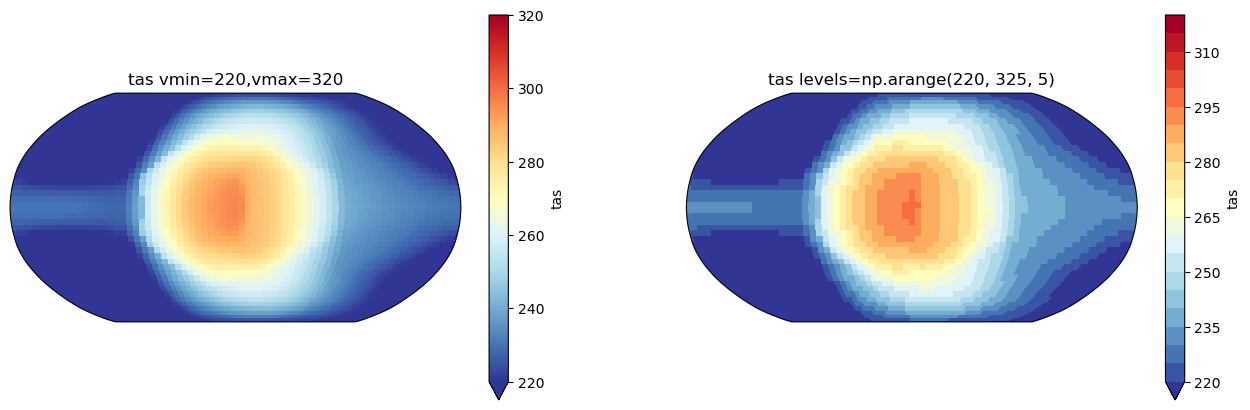

In [10]:
# Create matplotlib figure with Robinson projection
# See https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
fig, axs = libs.utils.create_figure(
    shape=(1, 2), # Figure with 1x2 subfigures
    height=5,     # Subfigure has height of '5'
    width=8,      # Subfigure has width of 5
    projection=ccrs.Robinson(central_longitude=0)
)

# Note addition of transform=ccrs.PlateCarree() to plot
# function arguments if using a cartopy projection!
gcm_slice\
    ['tas']\
    .plot(
        ax=axs[0],
        x='lon',
        transform=ccrs.PlateCarree(),
        y='lat',
        # you can also add a custom colormap:
        # https://matplotlib.org/stable/gallery/color/colormap_reference.html
        cmap='RdYlBu_r',
        # and set maximum/minimum values
        vmin=220,
        vmax=320
    )

axs[0].set_title('tas vmin=220,vmax=320')

gcm_slice\
    ['tas']\
    .plot(
        ax=axs[1],
        x='lon',
        transform=ccrs.PlateCarree(),
        y='lat',
        # you can also add a custom colormap:
        # https://matplotlib.org/stable/gallery/color/colormap_reference.html
        cmap='RdYlBu_r',
        # instead of max/min values, set discrete intervals of 5 from 260 to 300
        levels=np.arange(220, 325, 5)
    )

axs[1].set_title('tas levels=np.arange(220, 325, 5)');

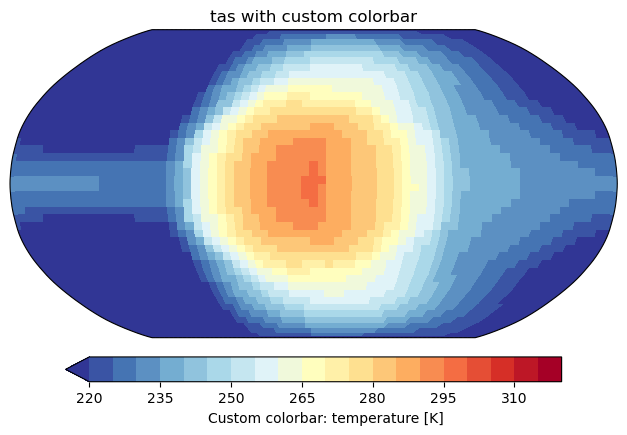

In [11]:
# Customise the colorbar

# Create matplotlib figure with Robinson projection
# See https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
fig, axs = libs.utils.create_figure(
    shape=(1, 1), # Figure with 1x1 subfigures
    height=5,     # Subfigure has height of '5'
    width=8,      # Subfigure has width of 5
    projection=ccrs.Robinson(central_longitude=0)
)

# Note add_colorbar argument in plot function
# and storing the plotted subfig in a variable `subfig`
subfig = gcm_slice\
    ['tas']\
    .plot(
        add_colorbar=False,
        ax=axs[0],
        x='lon',
        transform=ccrs.PlateCarree(),
        y='lat',
        cmap='RdYlBu_r',
        levels=np.arange(220, 325, 5)
    )

axs[0].set_title('tas with custom colorbar');

# Add custom colorbar
fig.colorbar(
    subfig,
    ax=axs[0],
    location='bottom', # location of colorbar
    pad=0.05,          # how much white space to add around colorbar
    shrink=0.8,        # shrink=1 is full size
    label='Custom colorbar: temperature [K]'
);

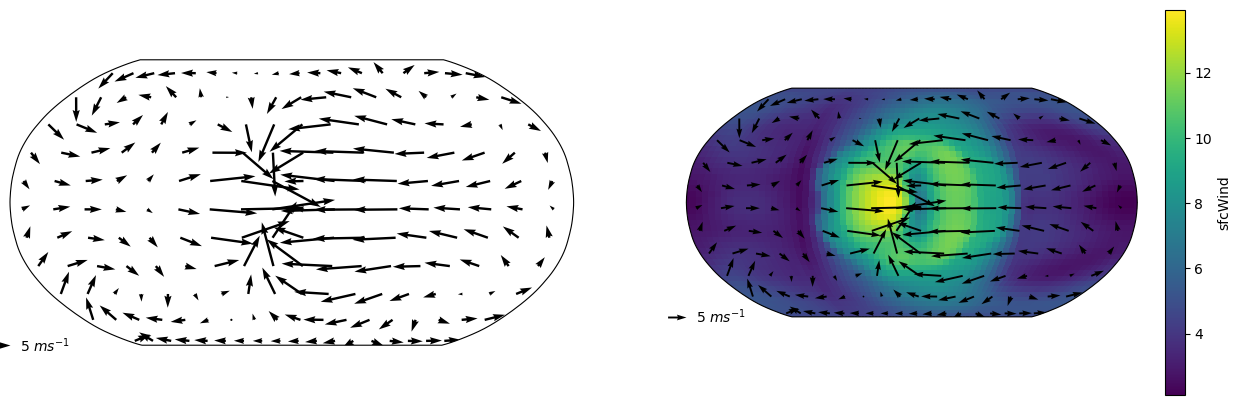

In [12]:
# We can also plot vectors, e.g. of wind:

# Create matplotlib figure with Robinson projection
# See https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
fig, axs = libs.utils.create_figure(
    shape=(1, 2), # Figure with 1x2 subfigures
    height=5,     # Subfigure has height of '5'
    width=8,      # Subfigure has width of 5
    projection=ccrs.Robinson(central_longitude=0)
)

# Plot quivers
plot_quiver(
    gcm_slice['uas'],
    gcm_slice['vas'],
    ax=axs[0],
    coarsen_kwargs={ 'lat': 4, 'lon': 4, 'boundary': 'trim' },
    quiver_kwargs={    
        'transform': ccrs.PlateCarree()
    }
)

# Plot magnitude background with quivers overlaid
gcm_slice['sfcWind'].plot(
    ax=axs[1],
    x='lon',
    transform=ccrs.PlateCarree(),
    y='lat'
)
plot_quiver(
    gcm_slice['uas'],
    gcm_slice['vas'],
    ax=axs[1],
    coarsen_kwargs={ 'lat': 4, 'lon': 4, 'boundary': 'trim' },
    quiver_kwargs={    
        'transform': ccrs.PlateCarree()
    }
)

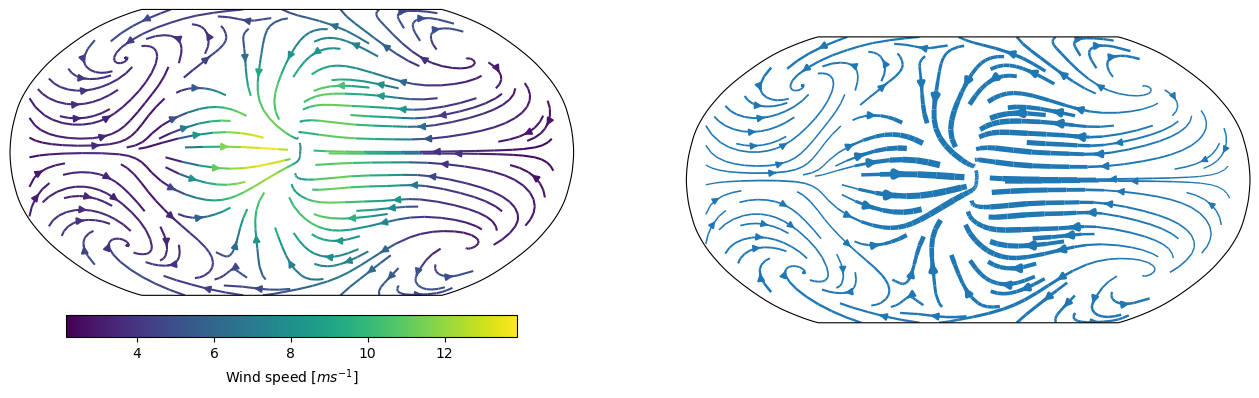

In [13]:
# Alternatively, plot streamlines instead of quivers

# Create matplotlib figure with Robinson projection
# See https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
fig, axs = libs.utils.create_figure(
    shape=(1, 2), # Figure with 1x2 subfigures
    height=5,     # Subfigure has height of '5'
    width=8,      # Subfigure has width of 5
    projection=ccrs.Robinson(central_longitude=0)
)

# Plot streamplot, varying color according to wind speed
subfig = plot_streamlines(
    gcm_slice['uas'],
    gcm_slice['vas'],
    ax=axs[0],
    streamplot_kwargs={
        'color': gcm_slice['sfcWind'].values,
        'transform': ccrs.PlateCarree()
    }
)

# Add custom colorbar
fig.colorbar(
    subfig.lines,      # note specifying '.lines' for colorbar
    ax=axs[0],
    location='bottom', # location of colorbar
    pad=0.05,          # how much white space to add around colorbar
    shrink=0.8,        # shrink=1 is full size
    label='Wind speed [$ms^{-1}$]'
);

# Plot streamplot, varying line width according to wind speed
linewidth = 5 * gcm_slice['sfcWind'] / gcm_slice['sfcWind'].max()           
subfig = plot_streamlines(
    gcm_slice['uas'],
    gcm_slice['vas'],
    ax=axs[1],
    streamplot_kwargs={
        # Vary color according to wind magnitude
        'linewidth': linewidth.values,
        'transform': ccrs.PlateCarree()
    }
)